In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import itertools
from download import download


In [10]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQVtdpXMHB4g9h75a0jw8CsrqSuQmP5eMIB2adpKR5hkRggwMwzFy5kB-AIThodhVHNLxlZYm8fuoWj/pub?gid=2105854808&single=true&output=csv'
path_target = "Times_Velos.csv"
download(url,path_target, replace = False)
bik_df = pd.read_csv(url)
#bik_df.describe()

Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.


In [11]:
bik_df.columns=['Date','Heure','Grandtotal',"Today's total",'Unnamed','Remark']
bik_df.drop(0, 0, inplace=True)
bik_df.drop(1, 0, inplace=True)

bik_df.pop("Unnamed")
bik_df.pop("Remark")
bik_df.pop("Grandtotal")

bik_df = bik_df.astype({"Today's total":'int'})
bik_df.isnull().sum()
bik_df = bik_df.dropna()
bik_df.isnull().sum()

Date             0
Heure            0
Today's total    0
dtype: int64

Text(0.5, 0, 'Date')

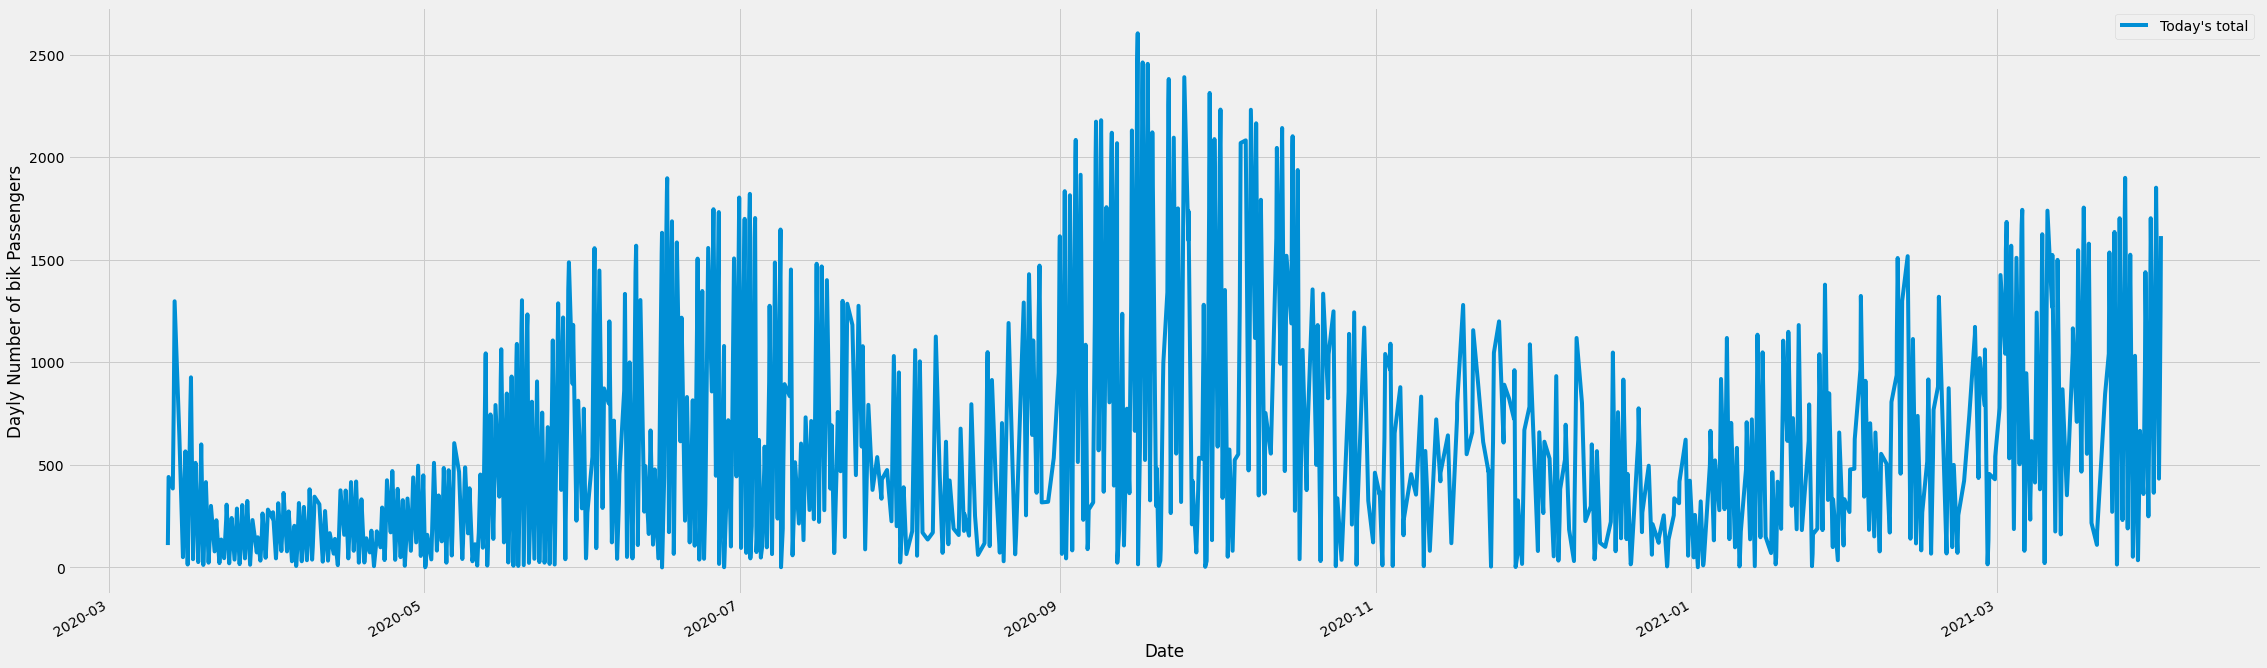

In [12]:
import datetime
import time
from datetime import date
standard_time = pd.to_datetime(bik_df['Date'] + ' ' + bik_df['Heure'],
                               format = '%d/%m/%Y %H:%M:%S')
# Where d = day, m=month, Y=year, H=hour, M=minutes

bik_df.insert(2,'Datetime', standard_time,True)
del bik_df['Date']
del bik_df['Heure']

ax = bik_df.set_index('Datetime').plot(figsize=(35, 12))
ax.set_ylabel('Dayly Number of bik Passengers')
ax.set_xlabel('Date')

In [13]:
bik_df['Year'] = bik_df['Datetime'].apply(lambda t: t.year)
bik_df['Day of Week'] = bik_df['Datetime'].apply(lambda time: time.dayofweek)

bik_df.columns=['Datetime',"Today's total",'Year','Day of Week']

bik_df = bik_df[bik_df['Year'] > 2020]
# Prendre que les données à partir du 01 Janvavier 2021
bik_df = bik_df[bik_df['Day of Week'] < 5]
# Prendre que les données correspondant aux jours de semaine

bik_df['matin'] = bik_df['Datetime'].apply(lambda t: t.hour)
bik_df = bik_df[bik_df['matin'] < 10]
bik_df = bik_df[bik_df['matin'] > 7]
#Prendre que les observations du matin
bik_df = bik_df.drop(columns = ['Year','Day of Week','matin'])

bik_df = bik_df.set_index(["Datetime"])

In [14]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    fig = plt.figure(figsize=(18,6))
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = pd.Series(timeseries).rolling(window=12).mean()

    #rolstd = pd.rolling_std(timeseries, window=12)#Plot rolling statistics:
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    plt.plot(timeseries, color='blue',label='Observed',linewidth=3)
    plt.plot(rolmean, color='red', label='Rolling Mean',linewidth=3)
    plt.plot(rolstd, color='black', label = 'Rolling Std',linewidth=3)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

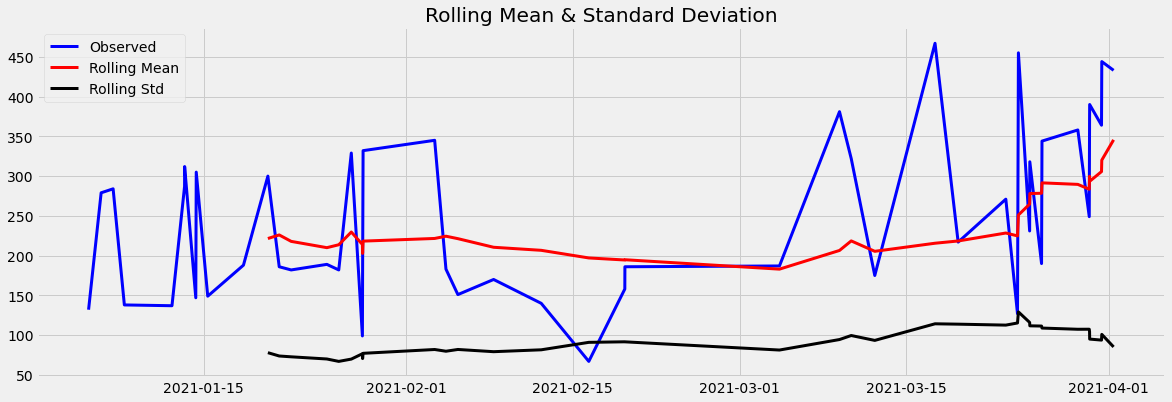

Results of Dickey-Fuller Test:
Test Statistic                 -2.867826
p-value                         0.049219
#Lags Used                      1.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64


In [15]:
test_stationarity(bik_df["Today's total"])

C:\Users\SADIO\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\SADIO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

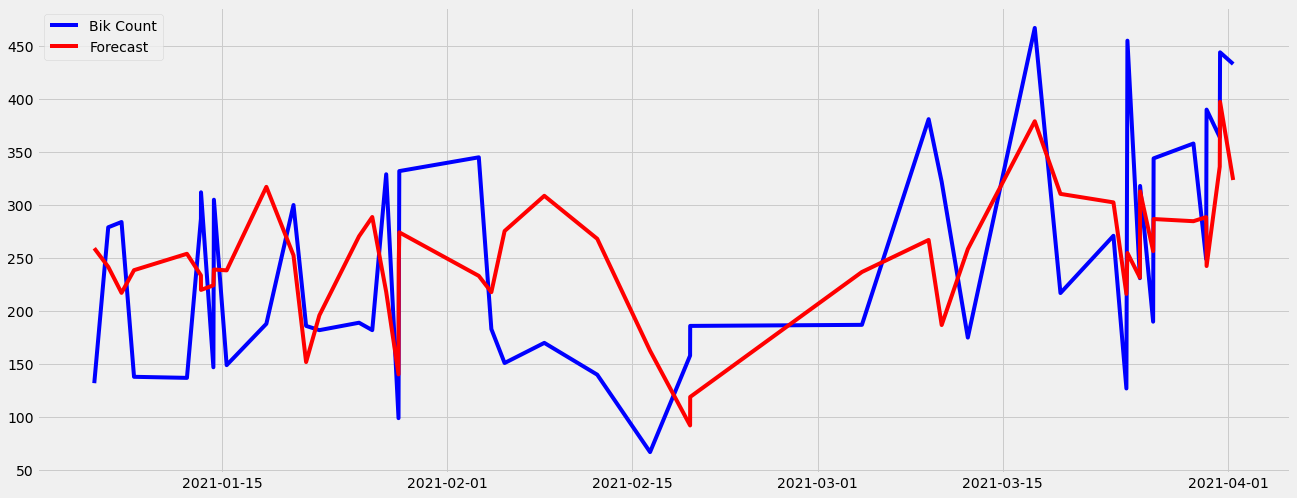

In [16]:
from statsmodels.tsa.arima_model import ARIMA
fig = plt.figure(figsize=(20,8))
model = ARIMA(bik_df["Today's total"].astype('float32'), order=(3,0,4)) 
ax = plt.gca()
results = model.fit()
plt.plot(bik_df["Today's total"], color='blue')
plt.plot(results.fittedvalues, color='red')
ax.legend(['Bik Count', 'Forecast'])

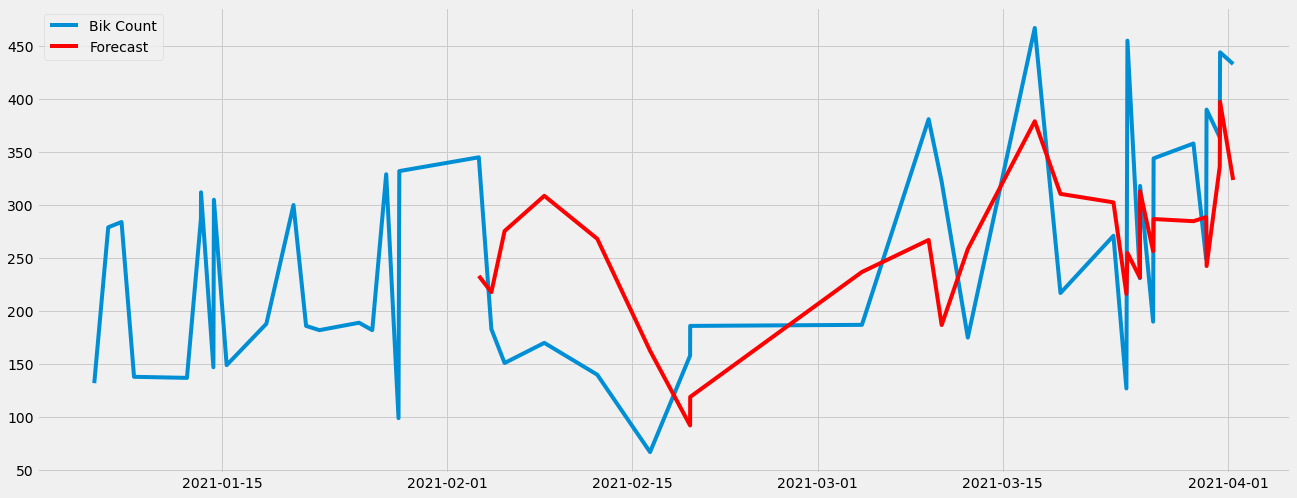

In [20]:
fig = plt.figure(figsize=(20,8))
x = results.predict(start=(20), end=(47), dynamic=False)
ax = plt.gca()
plt.plot(bik_df)
plt.plot(x, color='r')
ax.legend(['Bik Count', 'Forecast'])